In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

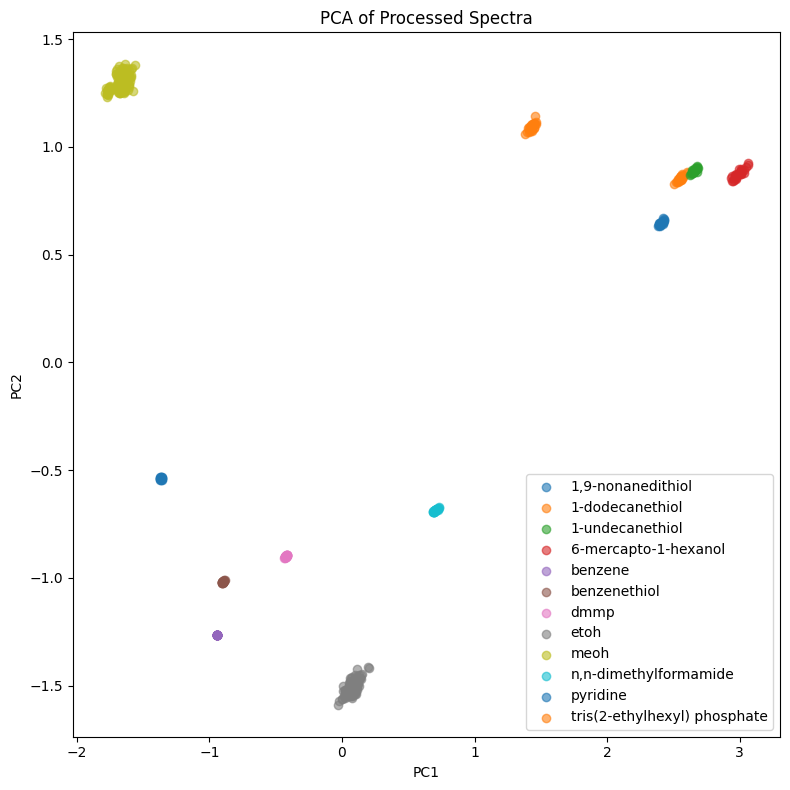

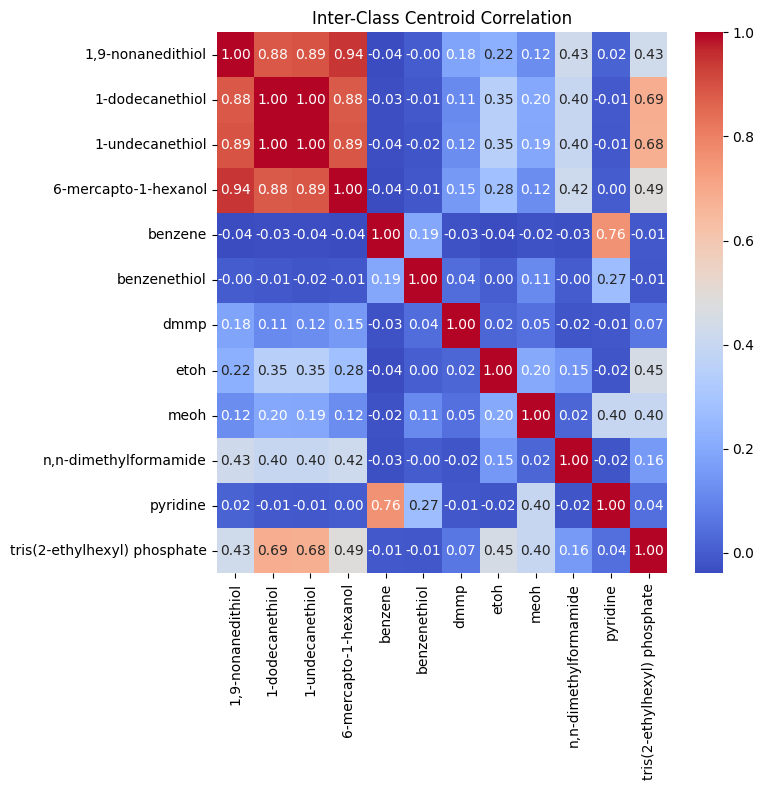

In [3]:
def baseline_AsLS(y,lam=1e4,p=0.01,niter =10):
    L =len(y)
    D = np.diff(np.eye(L),2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def minmax_normalize(arr):
    mn, mx = arr.min(), arr.max()
    return (arr - mn) / (mx - mn) if mx > mn else np.zeros_like(arr)

# --- Preprocess with baseline + minmax norm ---
def preprocess(spectra):
    """
    spectra: 2D array shape (n_samples, n_wavenumbers)
    returns: same shape, baseline-corrected then minmax-normalized
    """
    out = np.zeros_like(spectra, dtype=float)
    for i, spec in enumerate(spectra):
        bkg  = baseline_AsLS(spec)
        corr = spec - bkg
        out[i] = minmax_normalize(corr)
    return out

df = pd.read_csv('reference_Raman.csv')

wavs_str = df.columns[:-1]
wavs = wavs_str.astype(float)
wcols = wavs_str

spectra = df[wcols].values.astype(float)
species = df['Label'].values
proc = preprocess(spectra)

pca = PCA(n_components=2)
Z = pca.fit_transform(proc)

plt.figure(figsize=(8, 8))
for sp in np.unique(species):
    mask_sp = species == sp
    plt.scatter(Z[mask_sp,0], Z[mask_sp,1], label=sp, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Processed Spectra')
plt.legend()
plt.tight_layout()
plt.show()

# Compute class centroids
centroids = {}
for sp in np.unique(species):
    centroids[sp] = proc[species == sp].mean(axis=0)

# Build correlation matrix
corr_matrix = pd.DataFrame(index=centroids.keys(), columns=centroids.keys(), dtype=float)
for sp1 in centroids:
    for sp2 in centroids:
        corr = np.corrcoef(centroids[sp1], centroids[sp2])[0,1]
        corr_matrix.loc[sp1, sp2] = corr

# Display correlation heatmap
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Inter-Class Centroid Correlation')
plt.tight_layout()
plt.show()


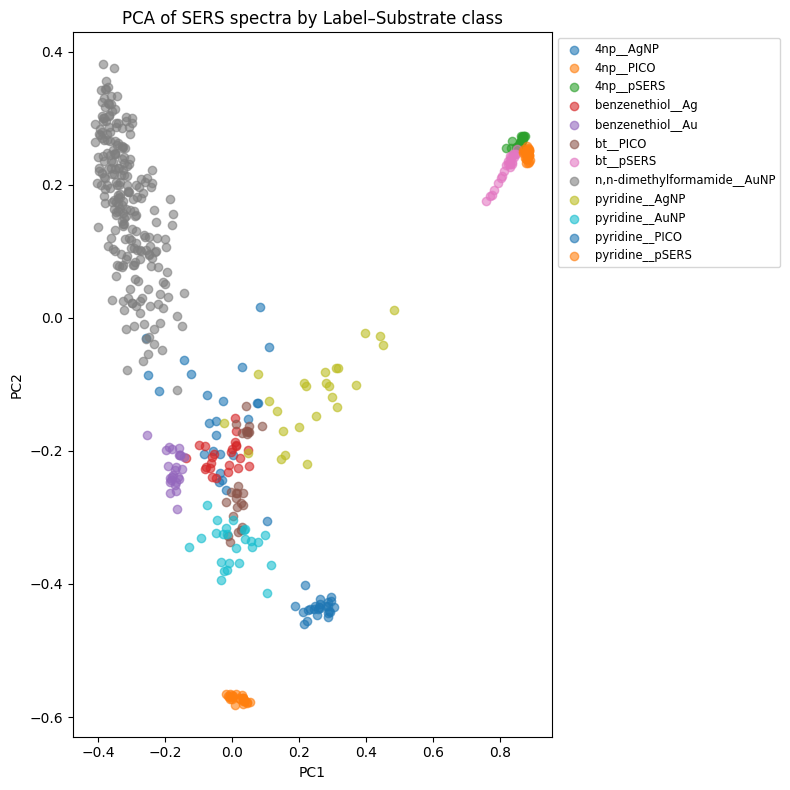

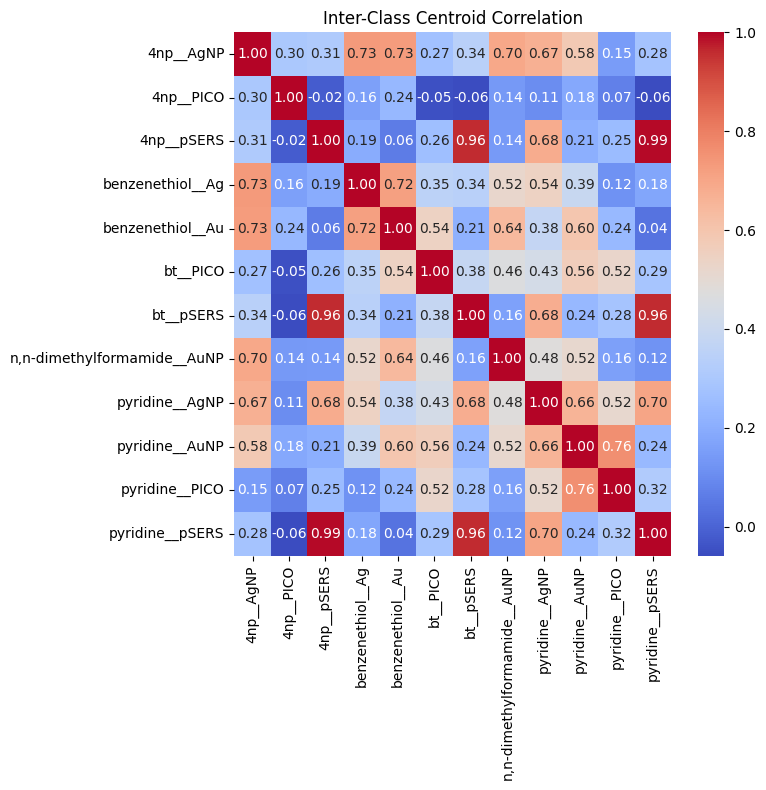

In [ ]:
def baseline_AsLS(y,lam=1e4,p=0.01,niter =10):
    L =len(y)
    D = np.diff(np.eye(L),2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg = baseline_AsLS(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

df = pd.read_csv('consolidated_SERS.csv')
df['Class'] = df['Label'].astype(str) + '__' + df['Substrate'].astype(str)

feature_cols = [c for c in df.columns if c not in ('Label','Substrate','Class')]
spectra     = df[feature_cols].values.astype(float)
classes     = df['Class'].values
proc = preprocess(spectra)

pca = PCA(n_components=2)
Z = pca.fit_transform(proc)

unique_labels = df['BaseLab'].unique()
marker_list   = ['o','s','^','v','P','X','D','*','<','>']  # at least as many as labels
marker_map    = {lab: marker_list[i] for i, lab in enumerate(unique_labels)}

# 4) Plot, coloring by Class but shaping by BaseLab
plt.figure(figsize=(8,8))
for cls in df['Class'].unique():
    mask = df['Class'] == cls
    lab  = df.loc[mask, 'BaseLab'].iat[0]
    plt.scatter(
        Z[mask,0], Z[mask,1],
        marker=marker_map[lab],
        alpha=0.7,
        label=cls
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: color=Class, shape=Label')
plt.legend(bbox_to_anchor=(1,1), fontsize='small')
plt.tight_layout()
plt.show()

# Compute class centroids
centroids = {
    cls: proc[classes==cls].mean(axis=0)
    for cls in np.unique(classes)
}
cm = pd.DataFrame(
    [[ np.corrcoef(centroids[a], centroids[b])[0,1]
       for b in centroids ] 
     for a in centroids],
    index = centroids.keys(),
    columns = centroids.keys()
)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Inter-Class Centroid Correlation')
plt.tight_layout()
plt.show()


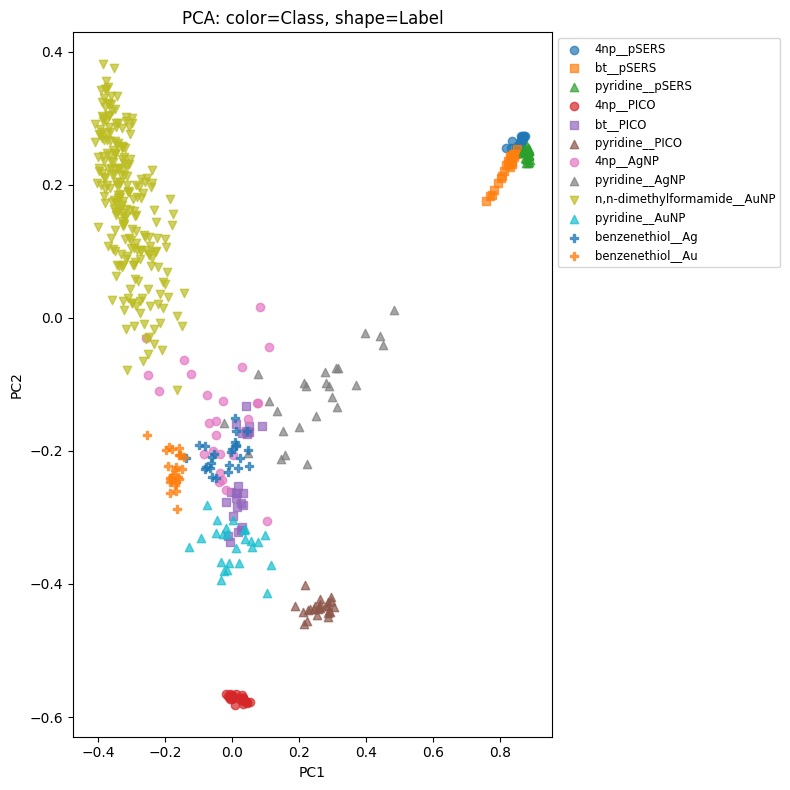

In [5]:
df['BaseLab'] = df['Label'] 
unique_labels = df['BaseLab'].unique()
marker_list   = ['o','s','^','v','P','X','D','*','<','>']  # at least as many as labels
marker_map    = {lab: marker_list[i] for i, lab in enumerate(unique_labels)}

# 4) Plot, coloring by Class but shaping by BaseLab
plt.figure(figsize=(8,8))
for cls in df['Class'].unique():
    mask = df['Class'] == cls
    lab  = df.loc[mask, 'BaseLab'].iat[0]
    plt.scatter(
        Z[mask,0], Z[mask,1],
        marker=marker_map[lab],
        alpha=0.7,
        label=cls
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: color=Class, shape=Label')
plt.legend(bbox_to_anchor=(1,1), fontsize='small')
plt.tight_layout()
plt.show()